In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [3]:
if not os.path.exists('output_data'):
    os.mkdir('output_data')

In [4]:
RAW_FILE = 'src_data/mpox_pgraph.csv'
pop_data = pd.read_csv('src_data/fairfax_population.csv')
infection_chance_per_day=[0.2,0.3,0.2,0.1,0.1,0.1,0.1,0.1] #1.2
cbgNames = set()
trans_data = {}

In [5]:
isheader = True
with open(RAW_FILE, 'r') as f:
    for line in f.readlines():
        if isheader:
            isheader = False
            continue
        cbgNames.add(line.strip().split(',')[0])
cbgNames = list(cbgNames)

In [6]:
isheader = True
with open(RAW_FILE, 'r') as f:
    for line in f.readlines():
        if isheader:
            isheader = False
            continue
        
        line = line.strip().split(',')
        fromCBG = cbgNames.index(line[0])
        toCBG = cbgNames.index(line[1])
        if fromCBG not in trans_data:
            trans_data[fromCBG] = []
            trans_data[fromCBG].append([])
            trans_data[fromCBG].append([])
        trans_data[fromCBG][0].append(toCBG)
        trans_data[fromCBG][1].append(float(line[3]))

In [6]:
nCBG = len(trans_data)

In [7]:
def idx_with_rand_probs(probs):
    val = random.random()
    cumuProb = 0
    for i, prob in enumerate(probs):
        cumuProb += prob
        if val < cumuProb:
            return i
    print('-1')
    return -1

In [8]:
population = []
for cbg in cbgNames:
    population.append(pop_data[pop_data['GeoId'] == int(cbg)]['Population'].item())


In [9]:
def initCase(numInitCase, cbgSIR, active_cases, newCaseIdx = None):
    if newCaseIdx is None:
        newCaseIdx = random.randint(0, nCBG - 1)
    
    numInitCase = min(numInitCase, cbgSIR['S'][-1][newCaseIdx])
    cbgSIR['S'][-1][newCaseIdx] -= numInitCase
    cbgSIR['I'][-1][newCaseIdx] += numInitCase
    
    for _ in range(int(numInitCase)):
        active_cases.append([newCaseIdx, 0])
    
    return numInitCase, newCaseIdx

def newCase(cbdIdx, cbgSIR, active_cases):
    
    srcCBGTrans = trans_data[cbdIdx]
    desCBGIdx = idx_with_rand_probs(srcCBGTrans[1])
    if desCBGIdx == -1:
        'The destination end with Susceptible'
        return
    desCBG = srcCBGTrans[0][desCBGIdx]

    active_cases.append([desCBG, 0])
    cbgSIR['S'][-1][desCBG] -= 1
    cbgSIR['I'][-1][desCBG] += 1
    
    
    if cbgSIR['S'][-1][desCBG] == 0:
        srcCBGTrans[0].pop(desCBGIdx)
        val = srcCBGTrans[1].pop(desCBGIdx)
        val = 1-val
        for i in range(len(srcCBGTrans[1])):
            srcCBGTrans[1][i] /= val




In [10]:
def nextDay(cbgSIR, active_cases):
    # Copy the latest SIR array
    for k in cbgSIR.keys():
        cbgSIR[k].append(np.copy(cbgSIR[k][-1]))
    
    i = 0
    while i < len(active_cases):
        case = active_cases[i]
        
        # Recovered
        if case[1] == len(infection_chance_per_day):
            cbgIdx = case[0]
            cbgSIR['I'][-1][cbgIdx] -= 1
            cbgSIR['R'][-1][cbgIdx] += 1

            active_cases.pop(i)
            # print('Recovered')
            continue
        
        infectionChance = infection_chance_per_day[case[1]]
        case[1] += 1
        i += 1
        
        if random.random() > infectionChance:
            # print('Unlucky')
            continue
        
        # One new case exist
        newCase(case[0], cbgSIR, active_cases)
        # print('Infected')
    

In [17]:
def startSimu(listNumInit, listIdxInit, simu_day=30, output_dir = None):
    active_cases = []
    cbgSIR = {'S':[np.array(population, dtype=int)], 'I':[np.zeros(nCBG, dtype=int)], 'R':[np.zeros(nCBG, dtype=int)]}
    listSucInit = []
    for numInit,idxInit in zip(listNumInit, listIdxInit):
        numInit,idxInit = initCase(numInit, cbgSIR, active_cases,idxInit)
        listSucInit.append((numInit,idxInit))
    
    print(len(active_cases))
    IPerDay = [sum(listNumInit)]
    for i in range(simu_day):
        nextDay(cbgSIR, active_cases)
        IPerDay.append(np.sum(cbgSIR['I'][-1]))
    plt.plot(IPerDay)
    print(listSucInit)
    
    if output_dir is not None:
        print('Saving results')
        out_path = 'output_data/%s/'%output_dir
        if not os.path.exists(out_path):
            os.mkdir(out_path)
        fullname = {'S':'susceptible', 'I':'infectious', 'R':'recovered'}
        for key in cbgSIR.keys():
            filename = '%s%s.csv'%(out_path, fullname[key])
            with open(filename, 'w') as fout:
                for daily_data in cbgSIR[key]:
                    for val in daily_data[:-1]:
                        fout.write('%d,'%val)
                    fout.write('%d\n'%daily_data[-1])
        
        with open('%smeta'%out_path, 'w') as fout:
            fout.write('Initial Cases (CBG, Number):\n')
            
            for num,idx in listSucInit:
                fout.write('\t%s, %d\n'%(cbgNames[idx], num))

            fout.write('Days of Simulation: %d\n'%simu_day)
            fout.write('R_0: %.1f\n'%sum(infection_chance_per_day))
            fout.write('R_0 breaks out in Days: ')
            for val in infection_chance_per_day:
                fout.write('%.1f '%val)
            fout.write('\n')

10
[(10, 342)]
Saving results


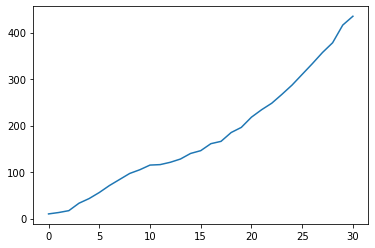

In [23]:
# initCBG = [random.randint(0,nCBG-1) for _ in range(5)]
# initNum = [10,50,30,10,20]

initCBG = [random.randint(0,nCBG-1)]
initNum = [10]
startSimu(initNum, initCBG ,output_dir='test')

Num of uninfected CBGs: 574


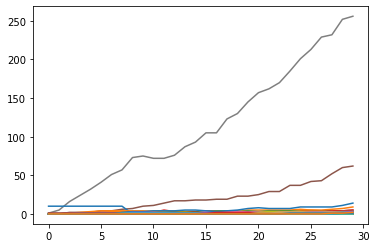

In [24]:
data = pd.read_csv('output_data/test/infectious.csv').to_numpy()
plt.figure()
sums = data.sum(axis=0)
count = 0
for i in range(nCBG):
    if sums[i] == 0:
        count += 1
        continue
    plt.plot(data[:,i])
print('Num of uninfected CBGs: %d'%count)